# INF367A Applied Machine Learning - Group project

* Elias Hovdenes
* Isak Pall Gestsson
* Magnus Sponnich Brørby

## Exploring Mental Health Data - Competition

### Exploring the dataset:

In [19]:
import matplotlib.pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split,HalvingGridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import numpy as np
import pandas as pd



In [ ]:
def process_dataset(dataset):
     
    dataset = pd.DataFrame(dataset)
     
    # setter 0 for missing verdier og så summer sammen A og W pressure i en pressure kolonne
    dataset.fillna({'Academic Pressure': 0}, inplace=True)
    dataset.fillna({'Work Pressure': 0}, inplace=True)

    dataset['Pressure'] = dataset['Academic Pressure'] + dataset['Work Pressure']

    # dropper 
    dataset.drop(['Academic Pressure', 'Work Pressure'], axis=1, inplace=True)

    return dataset
    

In [ ]:



file_path = "Data/train.csv"
file_path_test = "Data/test.csv"

trainingSet = pd.read_csv(file_path)
X_test = pd.read_csv(file_path_test)

processed_training = pd.DataFrame(trainingSet)

processed_training.fillna({'Academic Pressure': 0}, inplace=True)
processed_training.fillna({'Work Pressure': 0}, inplace=True)

# Create the 'Pressure' column by summing the two columns
processed_training['Pressure'] = processed_training['Academic Pressure'] + processed_training['Work Pressure']

# Drop the original columns if desired
processed_training.drop(['Academic Pressure', 'Work Pressure'], axis=1, inplace=True)


processed_test = pd.DataFrame(X_test)


processed_test.fillna({'Academic Pressure': 0}, inplace=True)
processed_test.fillna({'Work Pressure': 0}, inplace=True)

processed_test['Pressure'] = processed_test['Academic Pressure'] + processed_test['Work Pressure']

processed_test.drop(['Academic Pressure', 'Work Pressure'], axis=1, inplace=True)

print(processed_test)


X = processed_training.drop('Depression', axis=1)  
y = processed_training['Depression']  




X = pd.get_dummies(X) # vi må håndtere kategoriske features på en eller annen måte 
processed_test = pd.get_dummies(processed_test)





X_train, X_test = X.align(processed_test, join='left', axis=1, fill_value=0)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y, test_size=0.2, random_state=42, stratify=y)




#plt.hist(trainingSet["Age"].dropna(), bins=20, color='skyblue', edgecolor='black')
#plt.title("Age Distribution")
#plt.xlabel("Age")
#plt.ylabel("Frequency")
#plt.show()



           id     Name  Gender   Age           City  \
0      140700   Shivam    Male  53.0  Visakhapatnam   
1      140701    Sanya  Female  58.0        Kolkata   
2      140702     Yash    Male  53.0         Jaipur   
3      140703   Nalini  Female  23.0         Rajkot   
4      140704  Shaurya    Male  47.0         Kalyan   
...       ...      ...     ...   ...            ...   
93795  234495     Zoya  Female  49.0         Jaipur   
93796  234496    Shlok    Male  29.0      Ahmedabad   
93797  234497    Rishi    Male  24.0  Visakhapatnam   
93798  234498   Eshita  Female  23.0         Kalyan   
93799  234499    Gauri  Female  43.0       Varanasi   

      Working Professional or Student              Profession  CGPA  \
0                Working Professional                   Judge   NaN   
1                Working Professional  Educational Consultant   NaN   
2                Working Professional                 Teacher   NaN   
3                             Student                  

Data Preprocessing

In [8]:
def process_dataset(dataset):
     
    dataset = pd.DataFrame(dataset)
     
    # setter 0 for missing verdier og så summer sammen A og W pressure i en pressure kolonne
    dataset.fillna({'Academic Pressure': 0}, inplace=True)
    dataset.fillna({'Work Pressure': 0}, inplace=True)

    dataset['Pressure'] = dataset['Academic Pressure'] + dataset['Work Pressure']

    # dropper 
    dataset.drop(['Academic Pressure', 'Work Pressure'], axis=1, inplace=True)

    return dataset
    

            id   Age  CGPA  Study Satisfaction  Job Satisfaction  \
3429      3429  25.0  5.59                 5.0               NaN   
57741    57741  20.0  8.27                 4.0               NaN   
83234    83234  24.0  6.00                 2.0               NaN   
136573  136573  38.0   NaN                 NaN               3.0   
93261    93261  24.0  8.04                 4.0               NaN   
...        ...   ...   ...                 ...               ...   
41036    41036  60.0   NaN                 NaN               2.0   
108373  108373  56.0   NaN                 NaN               3.0   
75776    75776  60.0   NaN                 NaN               3.0   
117289  117289  21.0  5.75                 1.0               NaN   
127176  127176  43.0   NaN                 NaN               4.0   

        Work/Study Hours  Financial Stress  Name_18  Name_A.Ed  Name_Aadhya  \
3429                 8.0               5.0    False      False        False   
57741                0.0 

Modell

In [20]:
model = RandomForestClassifier(n_estimators= 100, criterion="gini", max_depth= 40, max_features="sqrt",random_state=42)
model.fit(X_train_split,y_train_split)

y_prediction = model.predict(X_val_split)


print(accuracy_score(y_val_split,y_prediction))



y_test_predict = model.predict(X_test)

feature_names = [f"feature {i}" for i in range(processed_training.shape[1])]
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#output = pd.DataFrame({'id': processed_test["id"], 'Depression': y_test_predict})
#output.to_csv('test_predictions.csv', index=False)


0.9320540156361052


ValueError: Length of values (774) does not match length of index (19)

Hyperparameter tuning RF


In [5]:
param_grid = {
    'n_estimators': [20,50,100],
    'criterion': ['entropy', 'gini'],
    'max_depth': [5, 10, 20 , 40],
    'max_features': ["sqrt", "log2"],
}


half_grid_search = HalvingGridSearchCV(estimator=model,param_grid=param_grid, factor=3, scoring='accuracy',cv=5)

half_grid_search.fit(X_train_split,y_train_split)

print(f"Beste parametere: {half_grid_search.best_params_}")


val_accuracy = half_grid_search.score(X_val_split,y_val_split)

print(f"Nøyaktighet på validation settet: {val_accuracy}")

KeyboardInterrupt: 

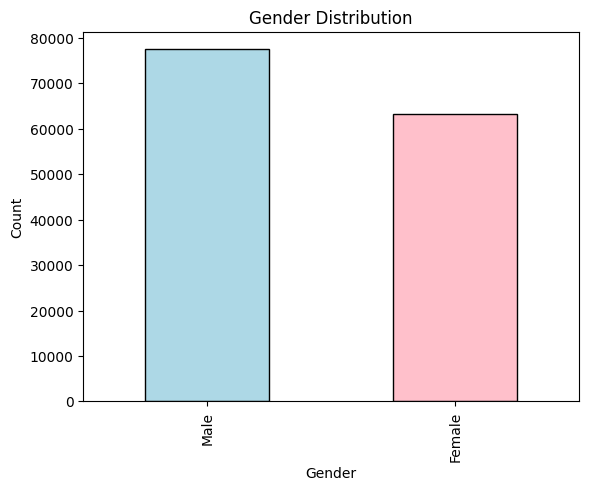

In [4]:
gender_counts = trainingSet["Gender"].value_counts()
gender_counts.plot(kind='bar', color=['lightblue', 'pink'], edgecolor='black')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

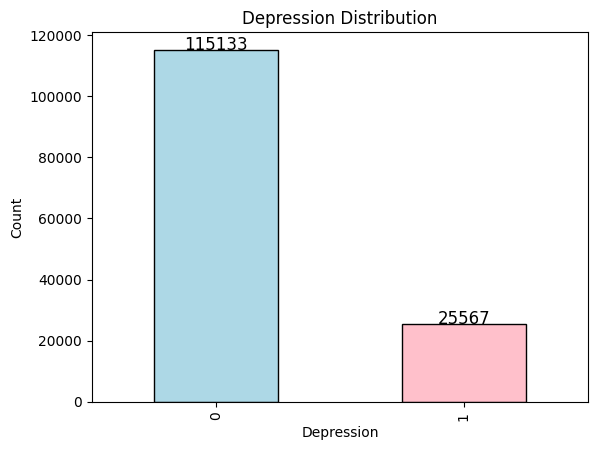

In [6]:
depression_counts = trainingSet["Depression"].value_counts()
depression_counts.plot(kind='bar', color=['lightblue', 'pink'], edgecolor='black')
plt.title("Depression Distribution")
plt.xlabel("Depression")
plt.ylabel("Count")
for i, count in enumerate(depression_counts):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)
plt.show()